# 0. Set up file 

In [1]:
%load_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
from scipy.interpolate import interp1d
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Python/python_from_R/Holocene/sampled_models/plotting_files/')
from plott import plott
import scipy.interpolate
#from mpl_toolkits.basemap import Basemap
matplotlib.use('agg')
from Cross_section import Cross_section
from Proxy_graph_masked import Proxy_graph
import Config
#from Map_plot import Map_plot
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
from matplotlib import lines
import time
from IPython import embed

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

fontsize = 25

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [3]:
# Define the d13C contour characterisics
cmap = 'gist_rainbow'
d13C_color_min = -0.5
d13C_color_max = 1.25
# d13C_color_levels = np.arange(d13C_color_min, d13C_color_max, (d13C_color_max-(d13C_color_min))/50)

# Import standardised latitudes and depths
lat_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/latitude_levels.csv', delimiter=',')
dep_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/depth_levels.csv', delimiter=',')


In [4]:
fh = Dataset('/srv/ccrc/data06/z5145948/UVic/PI/tavg.09920.01.01.nc')

o_dic13 = fh.variables['O_dic13'][:]
dep_U = fh.variables['depth'][:]
lon_U = fh.variables['longitude'][:]
lat_U = fh.variables['latitude'][:]

mask_U = o_dic13 / o_dic13

# #### import some UVic data

# # Set up graph

dep = dep_standardised
lat = lat_standardised                                                                                                                                                                                                                     

# # Adjust the mask

mask_U_original = mask_U.copy()

mask_U = np.mean(mask_U, axis = 0)

X, Y = np.meshgrid(dep_U, lat_U)
XI, YI  = np.meshgrid(dep_standardised, lat_standardised)

new_mask = np.empty((len(lon_U), len(lat_standardised), len(dep_standardised)))

for i in  np.arange(0, mask_U[0,0,:].shape[0]):
    mask_regridded_U = scipy.interpolate.griddata((X.flatten(), Y.flatten()), (mask_U[:,:,i].T).flatten() , (XI, YI),method='linear')
    new_mask[i,:,:] = mask_regridded_U

new_mask = new_mask.T
mask_U = new_mask
mask_U = np.ma.masked_where(mask_U == 0, mask_U)

mask = mask_U
lon = lon_U


In [5]:
####3 reading data function

def read_data(folder):

    # Import simulation details (summary) as dataframe
    summary = pd.read_csv(folder + '_summary.txt', delimiter = ' ')

    # Import simulation outputs
    fh = Dataset(folder + 'output.nc')
    proxy_simulations = fh.variables['var1_1'][:] 

    # Import samples (proxy data)
    samples = pd.read_csv( folder + '_samples.txt', delimiter = ' ')

    # Drop all unnecessary rows in summary
    summary = summary.drop(['type', 'Row.names', 'reps', 'model', 'dataset', 'filename', 'success.rate'], axis = 1)

    # Convert run.no to netcdf file index
    summary['run.no'] = summary['run.no'] - 1
    samples['run.no'] = samples['run.no'] - 1
    
    return(proxy_simulations, samples, summary)

In [6]:
# Define a function for reading and including cores that are in the Oliver compilation but not in the Peterson data set

def Oliver_cores(minn, maxx):
    import pandas as pd
    import numpy as np
    folder_location = '/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/'
    file_mat = ['GeoB4403_2.txt',
             'GeoB1028_5.txt',
             'GeoB2109_1.txt',
             'GeoB3801_6.txt',
             'V22_38.txt',
             'V28_56.txt',
             'V27_20.txt',
             'RC12_339.txt',
             'V32_128.txt',
             'GIK16772_1.txt',
             'MD96_2080.txt',
             'MD06_3018.txt',
             'NEAP18K.txt',
             'KNR140_37JPC.txt']


    location = ['Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Indian,','Pacific,','Atlantic,','Atlantic,','Pacific,','Atlantic,','Atlantic,']

    oliver_data = []

    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                oliver_data.append(location[i] + line)
        i += 1

    df = pd.DataFrame([sub.split(",") for sub in oliver_data])

    df.columns = ['Location','Core','Lat','Lon','Dep','Core depth','age','Species','pl1','pl2','d18O benthic','d13C']

    df = df[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df['d13C'] = [i.rstrip() for i in df['d13C']]

    df = df[df['age'].astype(float) > float(minn)]
    df = df[df['age'].astype(float) < float(maxx)]

    ################################# other data                                                                                                                                                                                                                                  

    file_mat = ['CH69_K09.txt',
    'MD03_2664.txt',
    'MD95_2042.txt',
    'U1308.txt',
    'ODP1063.txt']

    locations = ['CH69_K09\tAtlantic\t41.75\t-47.35\t4100\t',
              'MD03_2664\tAtlantic\t57.439000\t-48.605800\t3442.0\t',
              'MD95_2042\tAtlantic\t37.799833\t-10.166500\t3146.0\t',
              'U1308\tAtlantic\t49.877760\t-24.238110\t3871.0\t',
              'ODP1063\tAtlantic\t33.683333\t-57.616667\t4584\t']

    other_data = []
    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                other_data.append(locations[i]+line)
        i += 1

    df2 = pd.DataFrame([sub.split("\t") for sub in other_data])

    df2.columns = ['Core','Location','Lat','Lon','Dep','Core Depth','age','d13C']

    df2 = df2[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df2['d13C'] = [i.rstrip() for i in df2['d13C']]

    df2 = df2[df2['age'].astype(float) > float(minn)]
    df2 = df2[df2['age'].astype(float) < float(maxx)]

    results = pd.concat([df, df2])

    results = results[results['d13C'] != '']

    results['d13C'] = results['d13C'].astype(float)
    results['Lat'] = results['Lat'].astype(float)
    results['Lon'] = results['Lon'].astype(float)
    results['Dep'] = results['Dep'].astype(float)

    return(results)    
    

In [7]:

def pl_cores(minn, maxx):

    names = ['Core', 'Location', 'Lat', 'Lon', 'Dep']

    # Read in the data
    indopac = pd.read_table("../Moving_water_mass/Data/Core_files/indopac_core_data_LS16.txt", delimiter = ',', names = names)
    atl = pd.read_table("../Moving_water_mass/Data/Core_files/atl_core_data_LS16.txt", delimiter = ',', names = names)
    add = pd.read_table("../Moving_water_mass/Data/Core_files/Additional_core_locations.txt", delimiter = ',', usecols = [0, 1, 2, 3, 4], names = names)

    # Join all into a single dataframe
    df = indopac.append(atl)
    df = df.append(add)
    df = df.reset_index(drop = True)

    df['d18O names'] = df['Core'] + '_ageLS16.txt'
    df['d13C names'] = df['Core'] + '_d13C.txt'

    # Loop over the dataset and interpolate each core
    i = 0
    results_dict = {}

    while i < df.count()[0]:

        try:
            df_d18O = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d18O names'], delim_whitespace = True, names = ['depth', 'age'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue
        try:
            df_d13C = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d13C names'], delim_whitespace = True, names = ['depth', 'd13C'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue

        df_d18O = df_d18O.dropna(subset = ['age']) 
        df_d13C = df_d13C.dropna(subset = ['d13C'])

        df_d18O = df_d18O.reset_index(drop = True)
        df_d13C = df_d13C.reset_index(drop = True)

        interp = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = True)
        try:
            df_d13C['age'] = interp(df_d13C['depth'])
        except:
            try:
                interp2 = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = False)
                df_d13C['age'] = interp2(df_d13C['depth'])
            except:
                i += 1
                continue

        df_d13C = df_d13C.dropna(subset = ['age'])
        df_d13C = df_d13C.reset_index(drop = True)

        df_d13C = df_d13C[df_d13C['age'] > minn]
        df_d13C = df_d13C[df_d13C['age'] < maxx]

        if len(df_d13C) > 0:
            df_results = df.drop(['d18O names', 'd13C names'], axis = 1)
            df_results = df_results.loc[df_results.index.repeat(len(df_d13C))].loc[[i]]

            df_d13C = df_d13C.drop(['depth'], axis = 1)

            df_results = df_results.reset_index(drop = True).join(df_d13C.reset_index(drop = True))
            results_dict.update({
                df_results.Core[0] : df_results.drop(['Core'], axis = 1)
            })

        i += 1
        
    df_results = pd.concat(results_dict).reset_index()
    df_results = df_results.rename(columns = {'level_0' : 'Core'})
    df_results = df_results.drop(['level_1'], axis = 1)

    return(df_results)
    

# 1. Getting proxy data

In [8]:
# ################## read in the oliver data using the predefined function

### Redo the age model for the peterson dataset

years = pd.read_csv('../Moving_water_mass/Data/year_range.txt', delimiter = ' ')

# Age range to look over
minn = 110
maxx = 140

df_pl = pl_cores(minn,maxx)

df_oliver = Oliver_cores(minn,maxx)

###################3 join the dataframes

df_results = df_pl.append(df_oliver)
  
#################### get only the atlantic cores

df = df_results.reset_index(drop = True)
df['Dep'] = abs(df['Dep'])

df_atl = df[df['Location'] == 'Atlantic']
df_atl = df_atl.reset_index(drop = True)
df_atl['age'] = df_atl.age.astype(float)

## 1.1 Proxy raw plot

In [9]:
# # Define which cores are to be included in the plot

# df_plot = df_atl[(df_atl.Lat > 45)]

# # Set up thye figure
# fig = plt.figure(figsize = (15, 5))
# ax1 = plt.subplot2grid((1,1),(0,0))

# # Lists to be populated during looping
# core_list = []
# colours_list = []

# # Loop over the df, grouped by cores (plot each core as a single series)
# for core, group in df_plot.groupby('Core'):
#     c = np.random.rand(3,1).ravel()
#     output = ax1.scatter(group['age'], group['d13C'], alpha = 0.6, c=c)
#     core_list.append(core)
#     colours_list.append(c)

# # Create a legend 
# custom_lines = [Line2D([0], [0], color=c, lw=4) for c in colours_list]
# ax1.legend(custom_lines, core_list, loc='top right', fontsize = 8, ncol = 1)

# # format graph
# ax1.invert_xaxis()
# ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1]-5)
# ax1.set_title('Raw proxy data in time series')
# ax1.set_xlabel('Time (kaBP)')
# ax1.set_ylabel('d13C (permil)')

# print('')

# Stat models

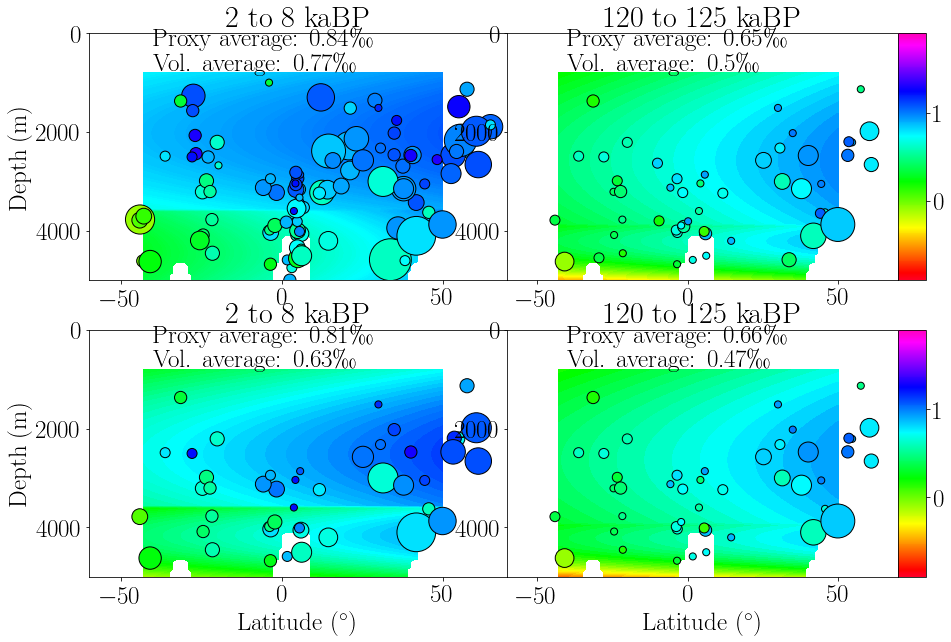

In [10]:
d13C_color_max = 1.9
d13C_color_min = -0.9
cmap= 'gist_rainbow'

fontsize = 25

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

# Create the plotting function
def plotting_stat_models(summary, samples, proxy_simulations, ax):
    
#     for run in np.unique(summary_Hol[(summary_Hol.equation == 'quad') &
#                                      (summary_Hol.lower == np.min(summary_Hol.lower))]['run.no']):

    run = 0
    # Get the year boundaries of the subplot
    summary_lower = summary[summary.index == run]['lower'].reset_index(drop = True)[0]
    summary_upper = summary[summary.index == run]['upper'].reset_index(drop = True)[0]

    # get the samples just for this run
    run_samples = samples[samples['run.no'] == run]

    # plot the run proxy samples
    output = ax.scatter(run_samples['Lat'],
                run_samples['Ocean_depth'],
                c = run_samples['d13C'],
                s = run_samples['count']*50,
                cmap = cmap,
                vmin = d13C_color_min,
                vmax = d13C_color_max,
                edgecolor = 'k')

    # plot the statistical model
    ax.contourf(
                lat_standardised,
                dep_standardised,
                proxy_simulations[run,:,:], 
                100,
                cmap = cmap,
                vmin = d13C_color_min,
                vmax = d13C_color_max,
                zorder = -1000
                        )

    # Average of proxies
    ax.text(-40, 250, "Proxy average: {}$\permil$".format(round(np.mean(samples['d13C']), 2)))

    # Find volume weighted average of the stat. model

    d13CX = np.repeat(proxy_simulations[run,:,:][:, :, np.newaxis], len(lon), axis=2) * mask
    d13CX = np.ma.masked_invalid(d13CX)

    wt = np.cos(np.tile(abs(lat[:,None])*np.pi/180,(1,len(lon))))
    wt2 = np.repeat(wt[np.newaxis, :, :], len(dep), axis=0)
    d13CX_avg = np.sum(d13CX * wt2 * ~d13CX.mask)/np.sum(wt2* ~d13CX.mask)

    ax.text(-40, 750, "Vol. average: {}$\permil$".format(round(d13CX_avg, 2)))

    # Correct the axes
    ax.set_ylim(5000,0)
    ax.set_xlim(-60,70)
    ax.set_title('{} to {} kaBP'.format(summary_lower, summary_upper))        

    return(output)
    
# Run the function
    
fig = plt.figure(figsize = (15, 10))

ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(1,0))
ax3 = plt.subplot2grid((2,2),(0,1))
ax4 = plt.subplot2grid((2,2),(1,1))

# Read data
proxy_simulations_Hol, samples_Hol_all, summary_Hol_all = read_data(
    '/srv/ccrc/data06/z5145948/Moving_water_mass/Output_condensed/Proxy_informed_slices/Holocene/'
)
output = plotting_stat_models(summary_Hol_all, samples_Hol_all, proxy_simulations_Hol, ax1)

# Read data
proxy_simulations_Hol, samples_Hol_common, summary_Hol_common = read_data(
    '/srv/ccrc/data06/z5145948/Moving_water_mass/Output_condensed/Common_proxies/Holocene/'
)
output = plotting_stat_models(summary_Hol_common, samples_Hol_common, proxy_simulations_Hol, ax2)

# Read data
proxy_simulations_LIG, samples_LIG_all, summary_LIG_all = read_data(
    '/srv/ccrc/data06/z5145948/Moving_water_mass/Output_condensed/Proxy_informed_slices/LIG/'
)    
output = plotting_stat_models(summary_LIG_all, samples_LIG_all, proxy_simulations_LIG, ax3)

# Read data
proxy_simulations_LIG, samples_LIG_common, summary_LIG_common = read_data(
    '/srv/ccrc/data06/z5145948/Moving_water_mass/Output_condensed/Common_proxies/LIG/'
)    
output = plotting_stat_models(summary_LIG_common, samples_LIG_common, proxy_simulations_LIG, ax4)

# Adjust axes

# Cbar
for ax in [ax3,ax4]:
    divider = make_axes_locatable(ax)
    divider = divider.append_axes("right", size="7%", pad="0%")
    cbar = plt.colorbar(output,cax=divider,pad='0%')

ax2.set_xlabel('Latitude ($^\circ$)')    
ax4.set_xlabel('Latitude ($^\circ$)')  

ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('Depth (m)')

# Plot
    
plt.subplots_adjust(wspace = 0, hspace = 0.2)    

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

# plt.savefig('Figures/d13C_statistical_reconstruction.png')

plt.show()


In [11]:
# caption = [
#     'Reconstruction of 2-dimensional $\delta{13}$C',
#     'during the LIG ({} to {} kaBP) of depth with latitude.'.format((np.max(summary_LIG.lower)),(np.min(summary_LIG.lower))),
#     'The points represent the proxy data, with showing the average $\delta^{13}$C and size indicating the number of points',
#     'Contours show the reconstructed $\delta^{13}$C.'
# ]

# caption = ' '.join(caption)

# # Write to a file
# file1 = open("Figures/d13C_statistical_reconstruction_caption.tex","w") 
# file1.write(caption) 
# file1.close() #to change file access modes

# # Save the volume weighted average results

# df_vol_averaged_results = pd.DataFrame.from_dict(vol_averaged_results,orient='index').sort_index().reset_index(drop=False)
# df_vol_averaged_results = df_vol_averaged_results.rename(columns={'index' : 'years', 0:'d13C'})
# df_vol_averaged_results.to_csv('Data/Atlantic_LIG_profile_SM.csv')

In [12]:
# print(summary_Hol_all['a.NADW'])
# print(summary_LIG_all['a.NADW'])

In [13]:
# print('All data difference: {}permil'.format(0.81 - 0.46))
# print('Common data difference: {}permil'.format(0.63 - 0.42))

# Run the R function

In [14]:
stat_model_ocean_depth = 2000

In [15]:
%%R -i summary_Hol_common -i summary_LIG_common -o d13c_latitude_Hol -o d13c_latitude_LIG -o Lat -i stat_model_ocean_depth

Ocean_depth <- stat_model_ocean_depth
Lat <- seq(-40,60,5)

equation <- dget("/srv/ccrc/data06/z5145948/Moving_water_mass/form_NADW_quad.R")

# Holocene
a <- summary_Hol_common$a.NADW
b <- summary_Hol_common$b.NADW
c <- summary_Hol_common$c.NADW
e <- summary_Hol_common$e.NADW
d13c_latitude_Hol <- equation(a, b, c, e, Lat, Ocean_depth)

# LIG
a <- summary_LIG_common$a.NADW
b <- summary_LIG_common$b.NADW
c <- summary_LIG_common$c.NADW
e <- summary_LIG_common$e.NADW
d13c_latitude_LIG <- equation(a, b, c, e, Lat, Ocean_depth)

# Gradient Examination

In [16]:
samples_Hol_common = samples_Hol_common.sort_values(by='Lat')
samples_LIG_common = samples_LIG_common.sort_values(by='Lat')

samples_Hol_common_subset = samples_Hol_common[(samples_Hol_common.Ocean_depth < 3000)]
samples_LIG_common_subset = samples_LIG_common[(samples_LIG_common.Ocean_depth < 3000)]

### Spline approach

In [17]:
Hol_samples_lat_groups = {}

for key,group in samples_Hol_common_subset.groupby('Lat'):
    Hol_samples_lat_groups.update({
        key : np.mean(group)
    })
    
Hol_samples_lat_groups = pd.DataFrame.from_dict(Hol_samples_lat_groups,orient='index')

LIG_samples_lat_groups = {}

for key,group in samples_LIG_common_subset.groupby('Lat'):
    LIG_samples_lat_groups.update({
        key : np.mean(group)
    })
    
LIG_samples_lat_groups = pd.DataFrame.from_dict(LIG_samples_lat_groups,orient='index')

lat_grid = np.arange(-35,70,5)

Hol_spline = interp1d(Hol_samples_lat_groups.Lat, Hol_samples_lat_groups.d13C,kind='cubic',
                     fill_value='extrapolate')(lat_grid)
LIG_spline = interp1d(LIG_samples_lat_groups.Lat, LIG_samples_lat_groups.d13C,kind='cubic',
                     fill_value='extrapolate')(lat_grid)


### Moving average approach

In [18]:
window = 15
lat_range_min = list(np.arange(-40,70,1))
lat_range_max = lat_range_min[window:] + [70]

moving_average_Hol = {}
for lat_1, lat_2 in zip(lat_range_min,lat_range_max):
    moving_average_Hol.update({
        lat_1 : np.mean(samples_Hol_common_subset[(samples_Hol_common_subset.Lat > lat_1) & (samples_Hol_common_subset.Lat < lat_2)])
    })

df_moving_average_Hol = pd.DataFrame.from_dict(moving_average_Hol,orient='index')          

moving_average_LIG = {}
for lat_1, lat_2 in zip(lat_range_min,lat_range_max):
    moving_average_LIG.update({
        lat_1 : np.mean(samples_LIG_common_subset[(samples_LIG_common_subset.Lat > lat_1) & (samples_LIG_common_subset.Lat < lat_2)])
    })

df_moving_average_LIG = pd.DataFrame.from_dict(moving_average_LIG,orient='index')          


In [19]:
samples_LIG_common_subset

,Core,Lat,Lon,Ocean_depth,d13C,count,stdev,run.no
44,MD96-2080,-36.2667,19.475,2488,0.610000,2,0.056569,0
34,ODP1087,-31.4600,15.310,1372,0.166667,3,0.080829,0
41,GEOB2109-1,-27.9100,-45.880,2504,0.670000,2,0.240416,0
24,GeoB1710,-23.4300,11.700,2987,0.330000,2,0.183848,0
40,GEOB1028-5,-20.1000,9.190,2209,0.585000,2,0.077782,0
22,GeoB1115,-3.5600,-12.560,2945,0.800000,2,0.141421,0
27,GIK13519-1,5.6700,-19.850,2862,0.930000,1,NaN,0
26,GIK12392-1,25.1700,-16.850,2573,0.834000,5,0.093167,0
30,GIK16004,29.9800,-10.650,1512,0.940000,1,NaN,0
25,GeoB4216,30.6300,-12.400,2324,0.765000,2,0.106066,0


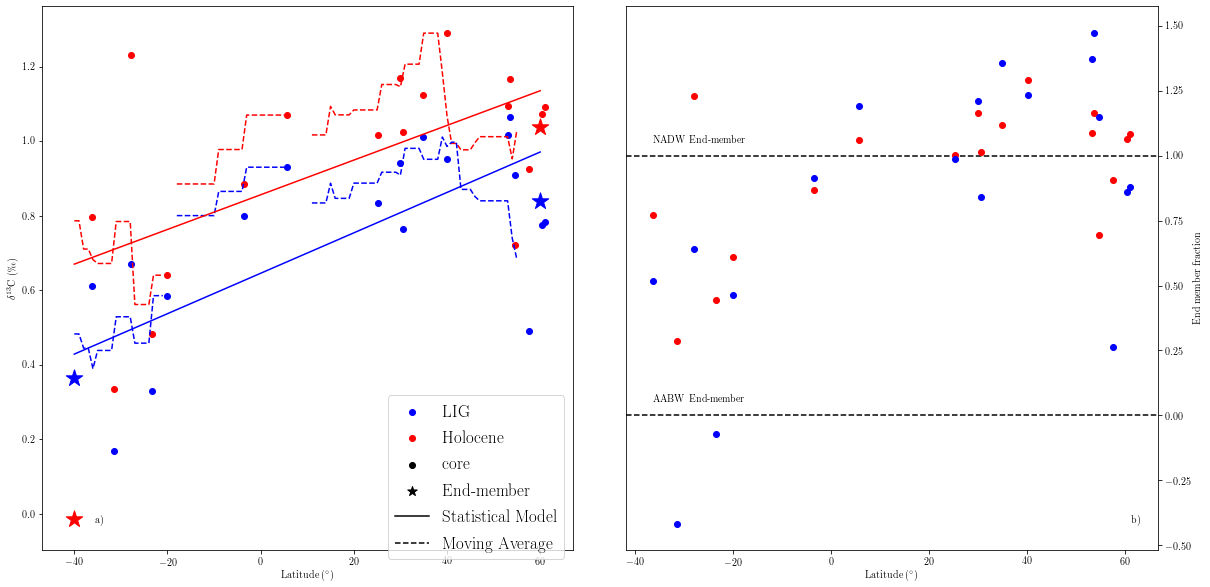

In [26]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,10))

ax1 = subplot2grid((1,2),(0,0))
ax2 = subplot2grid((1,2),(0,1))

# Plot the d13C values for each core relative to latitude

ax1.scatter(samples_Hol_common_subset.Lat, samples_Hol_common_subset.d13C,c='r')
ax1.scatter(samples_LIG_common_subset.Lat, samples_LIG_common_subset.d13C,c='b')

ax1.scatter(60,summary_Hol_all.N_mem,marker='*',c='r',s=300)
ax1.scatter(-40,summary_Hol_all.A_mem,marker='*',c='r',s=300)

ax1.scatter(60,summary_LIG_all.N_mem,marker='*',c='b',s=300)
ax1.scatter(-40,summary_LIG_all.A_mem,marker='*',c='b',s=300)

ax1.plot(df_moving_average_Hol.index, df_moving_average_Hol.d13C,'r--')
ax1.plot(df_moving_average_LIG.index, df_moving_average_LIG.d13C,'b--')

ax1.plot(Lat,d13c_latitude_Hol,c='r')
ax1.plot(Lat,d13c_latitude_LIG,c='b')

### Relative to end members

df_samples_EM_frac_Hol = pd.DataFrame(
    [(1-(summary_Hol_common.N_mem - x)/(summary_Hol_common.N_mem - summary_Hol_common.A_mem))
     for x in samples_Hol_common_subset.d13C])

df_samples_EM_frac_LIG = pd.DataFrame(
    [(1-(summary_LIG_common.N_mem - x)/(summary_LIG_common.N_mem - summary_LIG_common.A_mem))
     for x in samples_LIG_common_subset.d13C])

ax2.scatter(samples_Hol_common_subset.Lat, df_samples_EM_frac_Hol,c='r')
ax2.scatter(samples_LIG_common_subset.Lat, df_samples_EM_frac_LIG,c='b')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax1.set_ylabel('$\delta^{13}$C ($\permil$)')
ax2.set_ylabel('End member fraction')

ax2_xlims = ax2.get_xlim()
ax2.plot(ax2_xlims,[0,0],'k--',zorder=-100)
ax2.plot(ax2_xlims,[1,1],'k--',zorder=-100)
ax2.text(ax2_xlims[0]+0.05*np.diff(ax2_xlims),0.05,'AABW End-member')
ax2.text(ax2_xlims[0]+0.05*np.diff(ax2_xlims),1.05,'NADW End-member')
ax2.set_xlim(ax2_xlims)

ax1.set_xlabel('Latitude ($^{\circ}$)')
ax2.set_xlabel('Latitude ($^{\circ}$)')

ax1.text(ax1.get_xlim()[0]+0.1*np.diff(ax1.get_xlim()),
         ax1.get_ylim()[0]+0.05*np.diff(ax1.get_ylim()),
         'a)')
ax2.text(ax2.get_xlim()[1]-0.05*np.diff(ax2.get_xlim()),
         ax2.get_ylim()[0]+0.05*np.diff(ax2.get_ylim()),
         'b)')

LIG_leg = ax1.scatter([],[],marker='o',c='b')
Hol_leg = ax1.scatter([],[],marker='o',c='r')
core_leg = ax1.scatter([],[],marker='o',c='k')
EM_leg = ax1.scatter([],[],marker='*',c='k',s=100)
stat_leg = lines.Line2D([0,0],[0,0],c='k',linestyle='-')
moving_leg = lines.Line2D([0,0],[0,0],c='k',linestyle='--')

plt.legend([LIG_leg, Hol_leg, core_leg, EM_leg, stat_leg, moving_leg],
           ['LIG','Holocene','core','End-member','Statistical Model', 'Moving Average'],
          loc='best', bbox_to_anchor=(-0.6, -0.2, 0.5, 0.5),fontsize=17)

plt.subplots_adjust(wspace = 0.1, hspace = 0.2)  

#plt.suptitle('North-South $\delta^{13}$C Atlantic Profile')


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

#plt.savefig('Figures/Atlantic_profile.png',bbox_inches='tight')

plt.show()

In [21]:
caption = [
    'The north-south profile of the Atlantic Ocean benthic $\delta^{13}$C.',
    'Panel a, Holocene (red) and LIG (blue) core average $\delta^{13}C$ (points)',
    'and end-members (stars).',
    'Dotted lines are the moving averages of the cores.',
    'Solid lines are the statistical model $\delta^{13}$C results',
    'at {}m.'.format(stat_model_ocean_depth),
    'Panel b represents the core average $\delta^{13}$C as a fraction of the end-members;',
    'at a value of one, the core is equal to the NADW end-member',
    'and at a value of 0, the core is equal to the AABW end-member.'
]

caption = ' '.join(caption)

# Write to a file
# file1 = open("Figures/Atlantic_profile_caption.tex","w") 
# file1.write(caption) 
# file1.close() #to change file access modes

In [22]:
summary_Hol_common


,equation,period,run.no,dep_4,sigma,N_mem,A_mem,a.AABW,b.AABW,c.AABW,e.AABW,a.NADW,b.NADW,c.NADW,e.NADW,lower,upper
0,quad,Holocene,0,3600,0.268296,1.011958,0.06,0.005338,0.006866,-8.246980e-07,-13.614878,0.004657,0.000698,-1.384532e-07,0.014353,2,8


In [23]:
summary_Hol_common.A_mem

0    0.06
Name: A_mem, dtype: float64

In [24]:
summary_LIG_common


,equation,period,run.no,dep_4,sigma,N_mem,A_mem,a.AABW,b.AABW,c.AABW,e.AABW,a.NADW,b.NADW,c.NADW,e.NADW,lower,upper
0,quad,Holocene,0,3950,0.21898,0.839742,0.365,0.005642,0.012883,-0.000002,-26.588585,0.005427,0.000421,-7.984370e-08,0.122153,120,125


In [25]:
summary_LIG_common.A_mem

0    0.365
Name: A_mem, dtype: float64